## Week 2 Notebook - Data Storage

### Part 1
<p>The unix commands below are an example shell example for a simple conceptual Database  from the notes this week. <br>
<p><strong>EXCERCISE</strong> Try to <strong>modify the example to add an attraction from your city</strong> with it's own id.</p>
While this is not a realistic database as it is so simple, use this as a quick recap from the workshop last week and as a way to get familiar with mixing in some shell commands and scripts into you workbooks, it can be faster than python and you will need to do this for running some commands such as installation of libraries and git checkouts </p>
Try to break this down into steps and figure out how these functions work for yourself as an excercise. <br>
The best way to do this is to break each part of the storage and retrieval process down into steps. <br>
<strong>EXCERCISE</strong> Find out how <code>echo</code>, parameters (such as <code>$1</code>) and text processing utilities such as <code>grep</code>, <code>sed</code> and <code>tail</code> are combined together using <code> >> </code> and <code>||</code> .  <br>
<i>Hint</i> you can use <code>man</code> to find out more about a command and use the material from last week to help

In [1]:
%%bash
#!/bin/bash

# clear out any old database state
rm database

#setter function that stores an id and a record value with an id
db_set () {
	echo "$1,$2" >> database
}
#lookup a record value corresponding to a supplied an id
db_get () {
	grep "^$1," database | sed -e "s/^$1,//" | tail -n 1
}

#call the setter function to store some data in the database
db_set 42 '{"name":"San Francisco","attractions":["Golden Gate Bridge"]}'
db_set 44 '{"name":"London","attractions":["Tower Bridge","Buckingham Palace", "Big Ben"]}'
db_set 46 '{"name":"Dublin","attractions":["Trinity College","The Guinness Brewery"]}'

#EXCERCISE - ADD YOUR CITY HERE 

#look at the database contents
cat database

#lookup individual records not in order
echo 'lookup for rec 44'
db_get 44

echo 'lookup for rec 42'
db_get 42

#EXCERCISE - LOOKUP YOUR CITY HERE 

42,{"name":"San Francisco","attractions":["Golden Gate Bridge"]}
44,{"name":"London","attractions":["Tower Bridge","Buckingham Palace", "Big Ben"]}
46,{"name":"Dublin","attractions":["Trinity College","The Guinness Brewery"]}
lookup for rec 44
{"name":"London","attractions":["Tower Bridge","Buckingham Palace", "Big Ben"]}
lookup for rec 42
{"name":"San Francisco","attractions":["Golden Gate Bridge"]}


### Part 2
we cover lots of data storage formats this week from a computational perspective. This section demonstractes how to work with some of these formats and a comparison of their performance

In [17]:
# ensure pandas has support for parquet
# there are a number of libraries that support parquet and avaro but there are some dependency issues, 
# particularly with pandas so you may need to try a few alternatives to match the version of pandas installed and other libraries
# will will address these kinds of issues in future lectures about how to manage these sorts of dependency issues 
# using environments like Anaconda and containers Docker

# !conda install -c conda-forge fastparquet
# conda install -c conda-forge pyarrow
# !pip install fastparquet
!pip install pyarrow

# libraries to support parquet and avaro, 
# if you get installation errors remove these and from the save_functions list later in the notebook


# import fastparquet
import pyarrow

# import pandavro

import datetime
import hashlib
import os
import re
from uuid import uuid4
import datetime
from hashlib import sha1

import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

from sklearn import datasets

# setup globals
FOLDER = "data"

     |████████████████████████████████| 13.4 MB 4.1 MB/s eta 0:00:01


In [4]:
# utility methods to create a random dataset
# adapted from https://towardsdatascience.com/load-files-faster-into-bigquery-94355c4c086a
# https://github.com/niczky12/medium/blob/master/tech/bigquery/benchmarks/file_loads.py
    
def make_int(x: int) -> int:
    return int(x * 100_000)


def make_datetime(x: int) -> datetime.datetime:
    return datetime.datetime.fromtimestamp(abs(make_int(x)))


def make_string(x: int) -> str:
    return sha1(str(x).encode()).hexdigest()


def make_char(x: int) -> str:
    return chr(97 + (make_int(x) % 26))


def col_name_formatter(x: int) -> str:
    return f"col_{x:04d}"


def make_random_dataset(
    rows: int,
    float_cols: int = 1,
    int_cols: int = 1,
    datetime_cols: int = 1,
    string_cols: int = 1,
    char_cols: int = 1,
) -> pd.DataFrame:

    functions = [
        lambda x: x,
        make_int,
        make_datetime,
        make_string,
        make_char,
    ]

    quantities = [
        float_cols,
        int_cols,
        datetime_cols,
        string_cols,
        char_cols,
    ]

    total_columns = sum(quantities)

    X, _ = datasets.make_regression(
        n_samples=rows, n_features=total_columns
    )

    df = pd.DataFrame(
        X,
        columns=[
            col_name_formatter(i)
            for i in range(total_columns)
        ],
    )

    start_index = 0

    for fn, quantity in zip(functions, quantities):
        if quantity == 0:
            continue

        end_index = start_index + quantity
        df.iloc[:, start_index:end_index] = df.iloc[
            :, start_index:end_index
        ].applymap(fn)
        start_index = end_index

    return df

In [5]:
# a utility function to serialise as xml
# for xml parsing see https://docs.python.org/3/library/xml.etree.elementtree.html#building-xml-documents 
import xml.etree.ElementTree as et
from xml.etree.ElementTree import ElementTree

# lxml is a faster way of working with xml it is similar to etree
# from lxml import etree as et
root = et.Element('rows')

def build_item_xml(row):
    item1 = et.SubElement(root, 'row')
#   add a row identifier
    item1.set('id', str(row.name)) #setting the index as an attribute of the row tag
    
#   using the colum name as the tag name
    for column in df.columns:
        col = et.SubElement(item1, column)
        col.text = str(row[column])
    return row

def write_xml(df, filename, compress=False):
    df.apply(build_item_xml, axis=1) # this calls build_item_xml per row
    xml_data = et.tostring(root)  # get the serialised string
    
    target_encoding = 'utf-8'
    
    if compress:
        import gzip
        with gzip.open(filename, 'wb') as zipped_file:  # Write an XML file as binary
            ElementTree(root).write(zipped_file, encoding=target_encoding) #defaults to ascii
                       
    else:
        with open(filename, 'w') as f:  # Write an XML file as utf-8 text
            f.write(xml_data.decode(target_encoding)) #defaults to ascii

In [6]:
# create a small set of test data
df = make_random_dataset(10)

In [7]:
# show the contents of the dataframe
df

,col_0000,col_0001,col_0002,col_0003,col_0004
0,0.294110,119955.0,1970-01-01 19:34:17,4155a15cca6e6385176f686e144196fd73e72dc8,g
1,-0.662529,128446.0,1970-01-03 03:05:50,ecafd20e1e6f0f4046e2e21072fc221c3fb6c269,p
2,-2.116527,174965.0,1970-01-01 10:59:38,10c0670e69892b571d912b67d74c68dd14c48c1a,z
3,-0.712888,-105078.0,1970-01-02 01:40:07,ed4cdf57daa45351ec0ac5cb31cbe7d3910c854a,q
4,0.124305,-78855.0,1970-01-01 22:19:24,b24633fb11c0ba73f1999298027447fdaf849ec3,x
5,0.365939,58573.0,1970-01-02 09:28:21,af8184d7296ec2e8d96ff20000dffb06446c88f4,f
6,-0.191159,-80605.0,1970-01-01 01:57:07,1f7e50fd987becc4918014b9e799db3c847dc13d,b
7,-0.540759,27032.0,1970-01-01 11:50:08,ae02c5c52282e0a72c2128d5a65b71b10d6b1627,i
8,-1.099263,-87638.0,1970-01-01 14:07:59,0713b31a30734cd3b899e2826bc263c9c6cd52bc,x
9,0.690582,82059.0,1970-01-01 17:36:14,9922f96c75ea4cbacedcb8f32f6deebcc81a54fe,g


Save the data as (uncompressed) xml and print the contents using the command line


In [8]:
filename = 'output.xml'
# !rm output.xml
write_xml(df, filename)
!cat $filename

# if the version of pandas <= 1.0.X then the first row will be output twice, this is fixed in v 1.1

<rows><row id="0"><col_0000>0.2941096165021631</col_0000><col_0001>119955.0</col_0001><col_0002>1970-01-01 19:34:17</col_0002><col_0003>4155a15cca6e6385176f686e144196fd73e72dc8</col_0003><col_0004>g</col_0004></row><row id="0"><col_0000>0.2941096165021631</col_0000><col_0001>119955.0</col_0001><col_0002>1970-01-01 19:34:17</col_0002><col_0003>4155a15cca6e6385176f686e144196fd73e72dc8</col_0003><col_0004>g</col_0004></row><row id="1"><col_0000>-0.6625290863476673</col_0000><col_0001>128446.0</col_0001><col_0002>1970-01-03 03:05:50</col_0002><col_0003>ecafd20e1e6f0f4046e2e21072fc221c3fb6c269</col_0003><col_0004>p</col_0004></row><row id="2"><col_0000>-2.1165274495937294</col_0000><col_0001>174965.0</col_0001><col_0002>1970-01-01 10:59:38</col_0002><col_0003>10c0670e69892b571d912b67d74c68dd14c48c1a</col_0003><col_0004>z</col_0004></row><row id="3"><col_0000>-0.7128877284094842</col_0000><col_0001>-105078.0</col_0001><col_0002>1970-01-02 01:40:07</col_0002><col_0003>ed4cdf57daa45351ec0ac5cb

In [9]:
import pandas as pd
import xml.etree.ElementTree as et

def parse_XML(xml_file, df_cols): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """
    
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    
    for node in xroot: 
        res = []
        res.append(node.attrib.get(df_cols[0]))
        for el in df_cols[1:]: 
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else: 
                res.append(None)
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})
    
    out_df = pd.DataFrame(rows, columns=df_cols)
        
    return out_df

In [10]:
reloaded_df = parse_XML(filename, df.columns)
reloaded_df

,col_0000,col_0001,col_0002,col_0003,col_0004
0,None,119955.0,1970-01-01 19:34:17,4155a15cca6e6385176f686e144196fd73e72dc8,g
1,None,119955.0,1970-01-01 19:34:17,4155a15cca6e6385176f686e144196fd73e72dc8,g
2,None,128446.0,1970-01-03 03:05:50,ecafd20e1e6f0f4046e2e21072fc221c3fb6c269,p
3,None,174965.0,1970-01-01 10:59:38,10c0670e69892b571d912b67d74c68dd14c48c1a,z
4,None,-105078.0,1970-01-02 01:40:07,ed4cdf57daa45351ec0ac5cb31cbe7d3910c854a,q
5,None,-78855.0,1970-01-01 22:19:24,b24633fb11c0ba73f1999298027447fdaf849ec3,x
6,None,58573.0,1970-01-02 09:28:21,af8184d7296ec2e8d96ff20000dffb06446c88f4,f
7,None,-80605.0,1970-01-01 01:57:07,1f7e50fd987becc4918014b9e799db3c847dc13d,b
8,None,27032.0,1970-01-01 11:50:08,ae02c5c52282e0a72c2128d5a65b71b10d6b1627,i
9,None,-87638.0,1970-01-01 14:07:59,0713b31a30734cd3b899e2826bc263c9c6cd52bc,x


In [11]:
# save as json note this will save in a columar format by default
output_col = 'output_col.json'
df.to_json(output_col)
!cat $output_col

{"col_0000":{"0":0.2941096165,"1":-0.6625290863,"2":-2.1165274496,"3":-0.7128877284,"4":0.1243050206,"5":0.3659387187,"6":-0.1911593778,"7":-0.5407593486,"8":-1.0992631213,"9":0.6905815429},"col_0001":{"0":119955.0,"1":128446.0,"2":174965.0,"3":-105078.0,"4":-78855.0,"5":58573.0,"6":-80605.0,"7":27032.0,"8":-87638.0,"9":82059.0},"col_0002":{"0":70457000,"1":183950000,"2":39578000,"3":92407000,"4":80364000,"5":120501000,"6":7027000,"7":42608000,"8":50879000,"9":63374000},"col_0003":{"0":"4155a15cca6e6385176f686e144196fd73e72dc8","1":"ecafd20e1e6f0f4046e2e21072fc221c3fb6c269","2":"10c0670e69892b571d912b67d74c68dd14c48c1a","3":"ed4cdf57daa45351ec0ac5cb31cbe7d3910c854a","4":"b24633fb11c0ba73f1999298027447fdaf849ec3","5":"af8184d7296ec2e8d96ff20000dffb06446c88f4","6":"1f7e50fd987becc4918014b9e799db3c847dc13d","7":"ae02c5c52282e0a72c2128d5a65b71b10d6b1627","8":"0713b31a30734cd3b899e2826bc263c9c6cd52bc","9":"9922f96c75ea4cbacedcb8f32f6deebcc81a54fe"},"col_0004":{"0":"g","1":"p","2":"z","3":"q

In [12]:
# there are a number of other options including an output per record
output_row = 'output_row.json'
df.to_json(output_row, orient='records')
!cat $output_row

[{"col_0000":0.2941096165,"col_0001":119955.0,"col_0002":70457000,"col_0003":"4155a15cca6e6385176f686e144196fd73e72dc8","col_0004":"g"},{"col_0000":-0.6625290863,"col_0001":128446.0,"col_0002":183950000,"col_0003":"ecafd20e1e6f0f4046e2e21072fc221c3fb6c269","col_0004":"p"},{"col_0000":-2.1165274496,"col_0001":174965.0,"col_0002":39578000,"col_0003":"10c0670e69892b571d912b67d74c68dd14c48c1a","col_0004":"z"},{"col_0000":-0.7128877284,"col_0001":-105078.0,"col_0002":92407000,"col_0003":"ed4cdf57daa45351ec0ac5cb31cbe7d3910c854a","col_0004":"q"},{"col_0000":0.1243050206,"col_0001":-78855.0,"col_0002":80364000,"col_0003":"b24633fb11c0ba73f1999298027447fdaf849ec3","col_0004":"x"},{"col_0000":0.3659387187,"col_0001":58573.0,"col_0002":120501000,"col_0003":"af8184d7296ec2e8d96ff20000dffb06446c88f4","col_0004":"f"},{"col_0000":-0.1911593778,"col_0001":-80605.0,"col_0002":7027000,"col_0003":"1f7e50fd987becc4918014b9e799db3c847dc13d","col_0004":"b"},{"col_0000":-0.5407593486,"col_0001":27032.0,"col

The cell below output a dataframe in a range of formats, if there are issues with parquet or avaro due to dependency issues them comment these functions out.

There are some existing functions commented out as they require a HDFS (covered later in the course in more depth) or a database. 

**EXCERCISE** You can revisit the SQL function when you know how to connect to a database and try again

In [26]:
# make a small and a large dataset
# df = make_random_dataset(5000, 50, 50, 50, 50, 50)
# the 5000 dataset is quiet large and will take time to run, make sure you remove any space afterwards in the folder that stores the data

# use the small dataset for testing
df = make_random_dataset(5, 50, 50, 50, 50, 50)
large_df = pd.concat((df for _ in range(10)))

# save files to a folder
os.makedirs(FOLDER, exist_ok=True)

save_functions = {
    "csv": lambda df, fname: df.to_csv(
        f"{FOLDER}/CSV_{df.shape[0]}_{fname}.csv",
        index=False,
    ),
    "gzip": lambda df, fname: df.to_csv(
#         f"{FOLDER}/GZIP_{df.shape[0]}_{fname}.csv.gzip",
        f"{FOLDER}/GZIP_{df.shape[0]}_{fname}.csv.gz",
        index=False,
        compression="infer", #will look at the filename and try to guess, in this case it will use gzip
    ),
    "json": lambda df, fname: df.to_json(
        f"{FOLDER}/JSON_{df.shape[0]}_{fname}.json",
        orient='table',
        index=False,
        compression="infer", #will look at the filename and try to guess, in this case it will use gzip
    ),
    "pickle": lambda df, fname: df.to_pickle(
        f"{FOLDER}/PICKLE_{df.shape[0]}_{fname}.pickle.gz",
        compression="infer", #will look at the filename and try to guess, in this case it will use gzip
    ),
#     no built in support for xml as it depends on a number of factors so using our custom serialiser
    "xml": lambda df, fname: write_xml(df, 
        f"{FOLDER}/XML_{df.shape[0]}_{fname}.xml.gz",
        compress=True
    ),
    "parquet": lambda df, fname: df.to_parquet(
        f"{FOLDER}/PARQUET_{df.shape[0]}_{fname}.parquet",
        index=False,
    ),
    "avro": lambda df, fname: pandavro.to_avro(
        f"{FOLDER}/AVRO_{df.shape[0]}_{fname}.avro", df
    ),
    
#     other useful formats

#     REPLACE THIS WITH DATABASE DETAILS
#     "sql": lambda df, fname: df.to_sql(
#         name="tableName",
#         con="nameOfDataBase Connection"
#         index=False,
#     ),
    
#     to save into a HADOOP File System HDFS
#     see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_hdf.html
}

for save_function in save_functions.values():
    for fname, data in zip(
        ("small", "large"), (df, large_df)
    ):
        save_function(data, fname)


In [28]:
!ls -la $FOLDER

total 3593128
drwxr-xr-x  39 niall  staff       1248 15 Jan 01:08 .
drwxr-xr-x  30 niall  staff        960 15 Jan 01:09 ..
-rw-r--r--   1 niall  staff  174871659 15 Jan 01:09 AVRO_50000_large.avro
-rw-r--r--   1 niall  staff   17500440 15 Jan 01:08 AVRO_5000_small.avro
-rw-r--r--   1 niall  staff     189559 15 Jan 01:01 AVRO_50_large.avro
-rw-r--r--   1 niall  staff      32230 15 Jan 01:01 AVRO_5_small.avro
-rw-r--r--   1 niall  staff  228397830 15 Jan 01:03 CSV_50000_large.csv
-rw-r--r--   1 niall  staff  377901198 14 Jan 16:27 CSV_50000_large.json
-rw-r--r--   1 niall  staff   22841808 15 Jan 01:03 CSV_5000_small.csv
-rw-r--r--   1 niall  staff   37798362 14 Jan 16:27 CSV_5000_small.json
-rw-r--r--   1 niall  staff         39 14 Jan 16:53 CSV_5000_small.xml
-rw-r--r--   1 niall  staff     230840 15 Jan 01:01 CSV_50_large.csv
-rw-r--r--   1 niall  staff     387248 14 Jan 17:03 CSV_50_large.json
-rw-r--r--   1 niall  staff      25109 15 Jan 01:01 CSV_5_small.csv
-rw-r--r--   1 niall  s

**EXCERCISE** can you remember how to find the largest file in this folder using just the command line??

In [29]:
# compare file sizes
file_pattern = r"CSV|GZIP|JSON|PICKLE|XML|PARQUET|AVRO"

# if there are issues with parquet and avaro dependencies
# file_pattern = r"CSV|GZIP|JSON|PICKLE|XML" 
row_pattern = r"\d+"
file_names = [
    f"{FOLDER}/{f}"
    for f in os.listdir(FOLDER)
    if re.search(file_pattern, f)
]

file_info = []

file_size_mb = lambda fname: os.path.getsize(fname) / (
    2 ** 20
)

for fname in file_names:
    size = file_size_mb(fname)
    extension = re.search(file_pattern, fname).group()
    rows = int(re.search(row_pattern, fname).group())
    size = file_size_mb(fname)

    file_info.append(
        {
            "fname": fname,
            "extension": extension,
            "rows": rows,
            "size": size,
        }
    )


mkdir: benchmarks: File exists


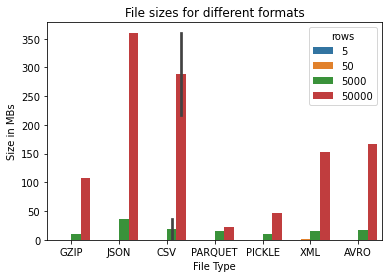

In [30]:
!mkdir benchmarks
# plot the sizes
ax = sns.barplot(
    x="extension",
    y="size",
    hue="rows",
    data=pd.DataFrame(file_info),
)
ax.set(xlabel="File Type", ylabel="Size in MBs")
plt.title("File sizes for different formats")
plt.savefig(
    "benchmarks/file_sizes.png", dpi=120
)
plt.show()

**EXCERCISE** try to run this again with different data sizes and see how these approaches scale with more records

**EXCERCISE** use the command line to remove any data files so they do not take up any uneeded space on your hard drive or on faculty<br>
BE CAREFUL when deleting files!!!